# <center>Welcome newcomer</center>

This Python notebook is a demonstration to understand the associated paper:
<center> [1] Olivier Leblanc, Mathias Hofer, Siddharth Sivankutty, Herve Rigneault, and Laurent Jacques, "Interferometric Lensless Imaging: Rank-one Projections of Image Frequencies with Speckle Illuminations". </center>

In this notebook, we start showing the image that will be observed through a MultiCore Fiber (MCF) with our new interferometric Lenless Imaging (LI) model. This image is a real mask that has been used for the practical experiments presented in [Section V, 1]. 

In [1]:
"""
    Copyright (c) 2023 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 15/05/2023

    Code description :
    __________________
    Reconstructs a piecewise constant 2D object using the ROP model and PyUnLocBox package.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers
import imageio

import sys, os
sys.path.append(os.path.join(os.getcwd(),'utils'))

from interferometric_lensless_imaging import * 
from graphics import *

We start representing the image of interest. We write the discrete image $f \in \mathbb R^{N\times N}$.

C:\Users\leblanco.OASIS\AppData\Local\Temp\ipykernel_16960\548401211.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f = imageio.imread(os.path.join(os.getcwd(), "images/f_ds.png")) / 255.


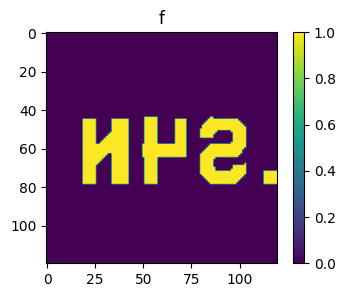

In [2]:
f = imageio.imread(os.path.join(os.getcwd(), "images/f_ds.png")) / 255.

# f is of resolution N x N
N = f.shape[0]

plt.figure(figsize=(4,3))
plt.imshow(f)
plt.colorbar()
plt.title(r"f")
plt.show()

<p align="center"><img src="images/interfero_LI.png" width="600px"></p>

We recall the observation model. We acquire a vector of single-pixel observations $\mathbf y \in \mathbb R^M$ 
$$
    \mathbf y = \mathcal B(f^\circ) =  \mathcal A \circ \mathbf{\mathcal{I}}_\Omega[f^\circ]
$$
where each measurement $m=1,\ldots,M$ applies Symmetric Rank-One Projections (SROP) of the interferometric matrix
$$
    \mathbf{\mathcal{I}}_\Omega[f^\circ]_{jk} := \iint_{\mathbb R^2} f^\circ (\mathbf x) e^{\frac{\mathrm i 2\pi}{\lambda z}(\mathbf p_k-\mathbf p_j)^\top \mathbf x} \mathrm d \mathbf x
$$  
and writes
$$
    y_m = \mathbf\alpha_m^* \mathbf{\mathcal{I}}_\Omega[f^\circ] \mathbf\alpha_m.
$$

The MCF of diameter $D$ is made of $Q$ cores with positions $\Omega := \{ \mathbf p_q \}_{q=1}^Q$ in the distal end plane $\mathcal Z_0$. Using the cores, we shape the light wavefront that will illuminate $f$ with the sketching vector $\mathbf\alpha:=(\alpha_1,\ldots,\alpha_Q)^\top$. We illuminate $f$ at a distance $z$ using monochromatic light at wavelength $\lambda$.

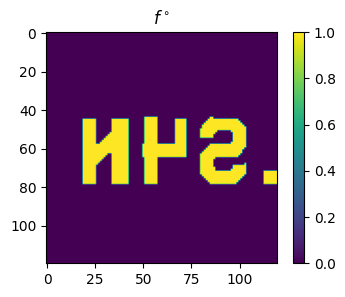

In [3]:
"Parameters"
M = 2000 # Number of observations (compared to N^2=16384 pixels)
Q = 120 # Number of cores
D = 176e-6 # MCF diameter
lamb = 1050e-9 # Laser wavelength
z = 500e-6 # Imaging depth
L = 300e-6 # Camera aperture width
Delta = L/N # Camera resolution [m/pixel]
lambz = lamb*z

"Cores positions"
pqx,pqy = LE_cores(D,Q)
# compute the pairwise differences between cores positions
Om_x = np.subtract.outer(pqx, pqx)
Om_y = np.subtract.outer(pqy, pqy)
# discretize the pairwise differences on the camera grid
Om_x2 = np.round(N*Om_x*Delta/lambz).astype(int)
Om_y2 = np.round(N*Om_y*Delta/lambz).astype(int)

"Apply FOV window"
x = np.linspace(-L/2,L/2,N)
xx,yy = np.meshgrid(x,x)
sig=L/8
# sqrtw = np.sqrt(np.exp(-(xx**2+yy**2)/(2*sig**2)))
sqrtw = np.ones(f.shape)
w=sqrtw**2

"complex amplitudes of each core"
a_ij = np.exp(1j*2*np.pi*np.random.rand(M,Q))
# a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) 

# forward and adjoint operators
B = lambda Xin: np.real(A(S_Om(T(w*Xin), Om_x2, Om_y2), a_ij, diagless=True))
Bt = lambda Xin: np.real(w* T_star(S_Om_star(A_star2(Xin, a_ij, diagless=True), Om_x2, Om_y2, f.shape) ) )

# measurement vector
y = B(f)


plt.figure(figsize=(4,3))
plt.imshow(w*f)
plt.colorbar()
plt.title(r"$f^\circ$")
plt.show()

**Remark:** in the cell above, the debiasing is ensured by removing the diagonal of the interferometric matrix with the option ``diagless=True`` in the definition of the operators. The measurement vector is thus already debiased by construction.

We now try to obtain a reconstruction of $f^\circ$ from the measurements $\boldsymbol y$. We solve
\begin{equation*}
    \hat{\boldsymbol{f}}^\circ = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \mathcal B(\boldsymbol{u}^\circ) \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}}
\end{equation*}

using the ``Forward-Backward`` (sometimes called ``Proximal Gradient``) algorithm:

\begin{cases}
  x^{(0)} = \mathcal B^*(\boldsymbol y) \\
  \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \mathcal B^*\big(\mathcal B(\boldsymbol x^{(k)})-\boldsymbol y\big) \right)
\end{cases}

using the classical momentum trick to accelerate the algorithm (not shown for brevity).

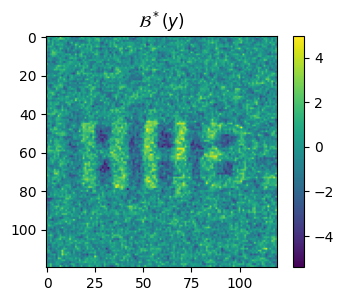

In [4]:
"initial condition"
adjoint = Bt(y)

plt.figure(figsize=(4,3))
plt.imshow(adjoint)
plt.title(r"$\mathcal{B}^*(y)$")
plt.colorbar()
plt.show()

Solution found after 28 iterations:
    objective function f(sol) = 4.931583e+02
    stopping criterion: RTOL


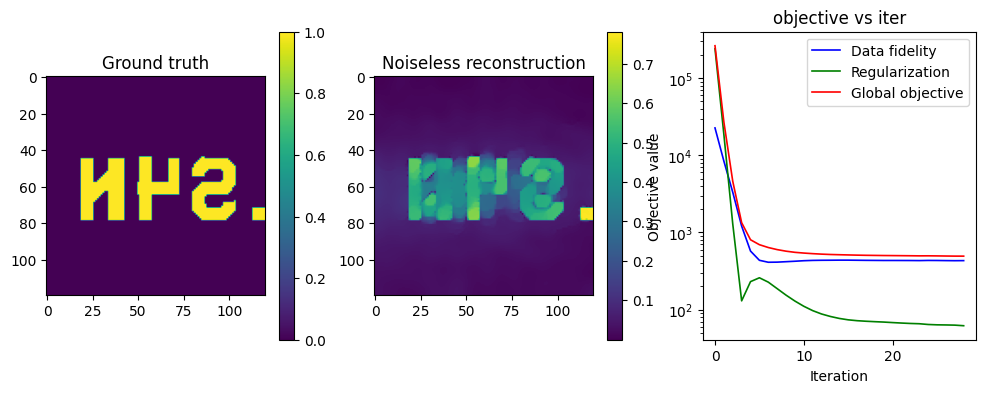

SNR: 4.17 dB


In [5]:
"reconstruction"
maxit=500 # max number of iterations
nu = eval_nu(np.random.randn(N,N), B, Bt, nb_iter=50)*1.01 # spectral norm of B, allows to set the step size below 1/L.
lambda_ = 1e-2 # regularization parameter

f1 = functions.norm_tv(maxit=80, dim=2, lambda_=lambda_)
f2 = functions.norm_l2(y=y, A=B, At=Bt, nu=nu)
solver = solvers.forward_backward(step=0.5/nu)
ret = solvers.solve(functions=[f1, f2], x0=adjoint, solver=solver, maxit=maxit)

show_rec2D(f, np.abs(ret['sol']), objective=ret['objective'], linewidth=1.2)

What we observe here above is that the recovery partially fails, because the recovery algorithm is blind to the mean of $f^\circ$ and we initialize the recovery algorithm with a zeromean adjoint. 
Let us then add a positivity constrain. We solve
\begin{equation*}
    \hat{\boldsymbol{f}}^\circ = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \mathcal B(\boldsymbol{u}^\circ) \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}} + \mathcal{i}_{\mathbb R_+} (\boldsymbol u)
\end{equation*}

using ``Generalized Forward-Backward`` algorithm:

\begin{cases}
    \boldsymbol x^{(0)} = \boldsymbol z_1^{(0)} = \boldsymbol z_2^{(0)} = \mathcal B^*(\boldsymbol y) \\
    \boldsymbol z_1^{(k+1)} = \boldsymbol z_1^{(k)} + \lambda \left(\text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \bigg(2 \boldsymbol x^{(k)} - \boldsymbol z_1^{(k)} - \gamma \mathcal B^*\big(\mathcal{B}(\boldsymbol x^{(k)}) - \boldsymbol y \big)\bigg) - \boldsymbol x^{(k)} \right) \\
    \boldsymbol z_2^{(k+1)} = \boldsymbol z_2^{(k)} + \mathcal{P}_{\mathbb R_+} \bigg(2 \boldsymbol x^{(k)} - \boldsymbol z_2^{(k)} - \gamma \mathcal B^*\big(\mathcal{B}(\boldsymbol x^{(k)}) - \boldsymbol y \big)\bigg) - \boldsymbol x^{(k)} \\
    \boldsymbol x^{(k+1)} = \frac{1}{2} \big(\boldsymbol z_1^{(k+1)}+\boldsymbol z_2^{(k+1)} \big)
\end{cases}

Solution found after 500 iterations:
    objective function f(sol) = 4.678854e+02
    stopping criterion: MAXIT


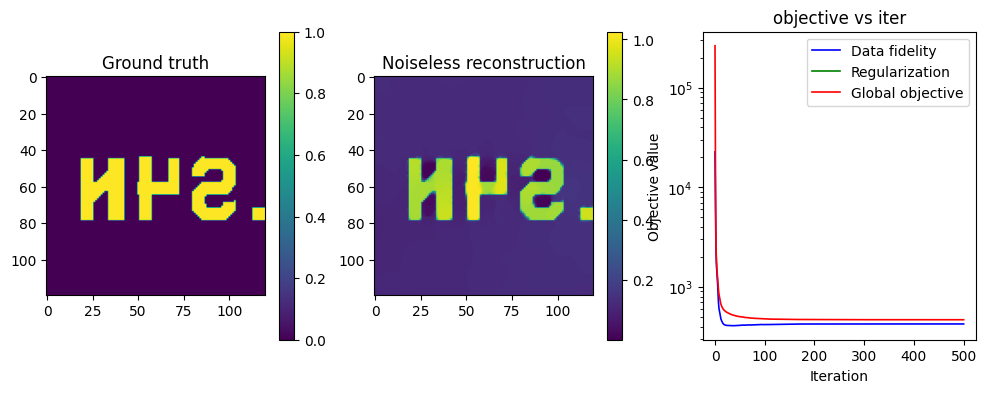

SNR: 8.83 dB


In [6]:
lambda_ = 1e-6 # regularization parameter
f1 = functions.norm_tv(maxit=80, dim=2, lambda_=lambda_)
solver = solvers.generalized_forward_backward(step=0.5/nu)
f3 = functions.proj_positive()
ret = solvers.solve(functions=[f1, f2, f3], x0=adjoint, solver=solver, rtol=1e-7, maxit=maxit) 

show_rec2D(f, np.abs(ret['sol']), objective=ret['objective'], linewidth=1.2)

We observe the reconstruction is much better when adding the positivity constrain!

We solve

\begin{equation*}
    \hat{\boldsymbol{f}}^\circ = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \mathcal B(\boldsymbol{u}^\circ) \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}} + \mathcal{i}_{\mathbb R_+} (\boldsymbol u)
\end{equation*}

using Generalized Forward-Backward as above, and with $\lambda$ being adapted between some meta-iterations.
We have 
$$
    \lambda^{(k+1)} = \lambda^{(k)} \frac{\epsilon}{\epsilon^{(k)}}
$$
for some noise tolerance $\epsilon: \| \boldsymbol y - \mathcal{B}(\hat{\boldsymbol{f}}^\circ) \| \le \epsilon.$

c:\Users\leblanco.OASIS\Anaconda3\envs\ILI3\lib\site-packages\pyunlocbox\functions.py:712: RuntimeWarning: invalid value encountered in double_scalars
  rel_obj = np.abs(obj - prev_obj) / obj


Solution found after 100 iterations:
    objective function f(sol) = 4.751554e+02
    stopping criterion: MAXIT
Solution found after 100 iterations:
    objective function f(sol) = 4.692304e+02
    stopping criterion: MAXIT
Solution found after 100 iterations:
    objective function f(sol) = 4.685402e+02
    stopping criterion: MAXIT
Solution found after 45 iterations:
    objective function f(sol) = 4.685064e+02
    stopping criterion: RTOL
Solution found after 19 iterations:
    objective function f(sol) = 4.685074e+02
    stopping criterion: RTOL
Solution found after 100 iterations:
    objective function f(sol) = 4.684582e+02
    stopping criterion: MAXIT


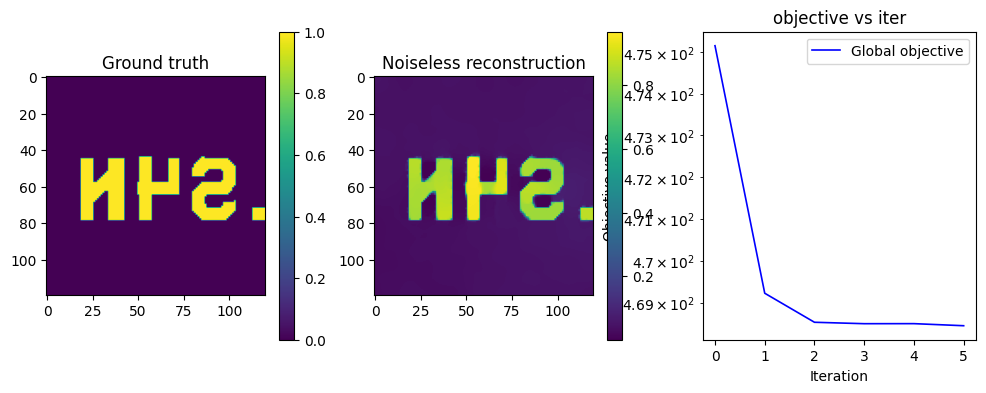

SNR: 13.97 dB


In [7]:
maxit=100 # max number of iterations for each meta-iteration
SNR_target = 40 # expected SNR of the reconstruction
epsilon = np.linalg.norm(f)*10**(-SNR_target/20) # noise tolerance
maxmit = 6 # number of meta-iterations

lamb1 = 1
f_hat1 = np.zeros(f.shape)
lambs1 = np.zeros(maxmit)
objectives1 = np.zeros(maxmit)
i=0
while (i<maxmit): 
    x0 = f_hat1
    f1 = functions.norm_tv(maxit=80, dim=2, lambda_=lamb1)
    ret1 = solvers.solve([f1, f2, f3], f_hat1, solver, rtol=1e-7, maxit=maxit) 
    f_hat1 = ret1['sol']
    lamb1 *= epsilon/np.linalg.norm(B(ret1['sol'])-y)
    lambs1[i] = lamb1
    objectives1[i] = np.sum(np.array(ret1['objective'])[-1,:])
    i+=1

show_rec2D(f, np.abs(ret1['sol']), objective=objectives1, linewidth=1.2)